In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def determine_topsoil_type(lutumfractie, os, a, b):
    # Following the notation y = ax + b
    leem = 100 - (a * os + b)

    if 0 <= os <= 15:
        if 0 <= lutumfractie <= 8:
            if 0 <= leem <= 10:
                return 1
            elif 10 < leem <= 18:
                return 2
            elif 18 < leem <= 33:
                return 3
            elif 33 < leem <= 50:
                return 4
            elif 50 < leem <= 100:
                return 5
        if 8 < lutumfractie <= 12:
            return 7
        elif 12 < lutumfractie <= 18:
            return 8
        elif 18 < lutumfractie <= 25:
            return 9
        elif 25 < lutumfractie <= 35:
            return 10
        elif 35 < lutumfractie <= 50:
            return 11
        elif 50 < lutumfractie <= 100:
            return 12
    elif lutumfractie < 8:
        if 15 < os < 25:
            return 15   
        elif 25 < os:
            return 16
    elif lutumfractie > 8:
        if 16 < os < 45:
            return 17
        elif 45 < os < 70:
            return 18

In [3]:
soil_samples_gdf = gpd.read_file("Data/topsoil_samples.gpkg")
soil_samples = soil_samples_gdf[["boorpunt_ID", "lutumgehalte", "organisch_stofgehalte"]].copy()
soil_samples = soil_samples.to_numpy()

In [4]:
def mcs_simulation(soil_samples, n_simulations, std_dev):
    for i in range(1, 18):
        if f'results_df_{i}' in globals():
            del globals()[f'results_df_{i}']
    
    # Create an empty DataFrame to store the results, one for each texture class with a column for each boorpunt_ID and a row for each simulation
    sample_ids = [f"{row[0]}_{idx}" for idx, row in enumerate(soil_samples)]
    for i in range(1, 18):
        globals()[f'results_df_{i}'] = pd.DataFrame(0, index=np.arange(n_simulations), columns=sample_ids)

    data_shape = soil_samples.shape
    results = np.zeros((n_simulations, data_shape[0]))

    for i in tqdm(range(n_simulations)):
        random_a = np.random.normal(-6, std_dev)
        random_b = np.random.normal(82, std_dev)
        
        # For each soil sample, determine the texture class and add a '1' to the corresponding column in the corresponding results DataFrame
        for j in range(data_shape[0]):
            sample_id = sample_ids[j]
            lutumfractie = soil_samples[j, 1]
            os = soil_samples[j, 2]

            texture_class = determine_topsoil_type(lutumfractie, os, random_a, random_b)
            if texture_class is not None:
                results[i, j] = texture_class
                globals()[f'results_df_{texture_class}'].loc[i, sample_id] += 1

    return

In [5]:
mcs_simulation(soil_samples, 100, 0.1)

100%|██████████| 100/100 [00:13<00:00,  7.37it/s]


In [6]:
# Add columns to each results DataFrame with the sum of '1's in each row
for i in range(1, 18):
    globals()[f'results_df_{i}']['sum'] = globals()[f'results_df_{i}'].sum(axis=1)

results_df_3.head()

,12088.0_0,17290.0_1,17291.0_2,17357.0_3,17365.0_4,24776.0_5,24777.0_6,12086.0_7,12087.0_8,17126.0_9,...,726792.0_1325,726793.0_1326,726794.0_1327,726797.0_1328,726799.0_1329,726802.0_1330,743330.0_1331,745259.0_1332,745260.0_1333,sum
0,1,1,0,1,0,0,1,0,0,1,...,1,0,1,1,1,1,0,1,1,787
1,1,1,0,1,0,0,1,0,0,1,...,1,0,1,1,1,1,0,1,1,787
2,1,1,0,1,0,0,1,0,0,1,...,1,0,1,1,1,1,0,1,1,773
3,1,1,0,1,0,0,1,0,0,1,...,1,0,1,1,1,1,0,1,1,787
4,1,1,0,1,0,0,1,0,0,1,...,1,0,1,1,1,1,0,1,1,790


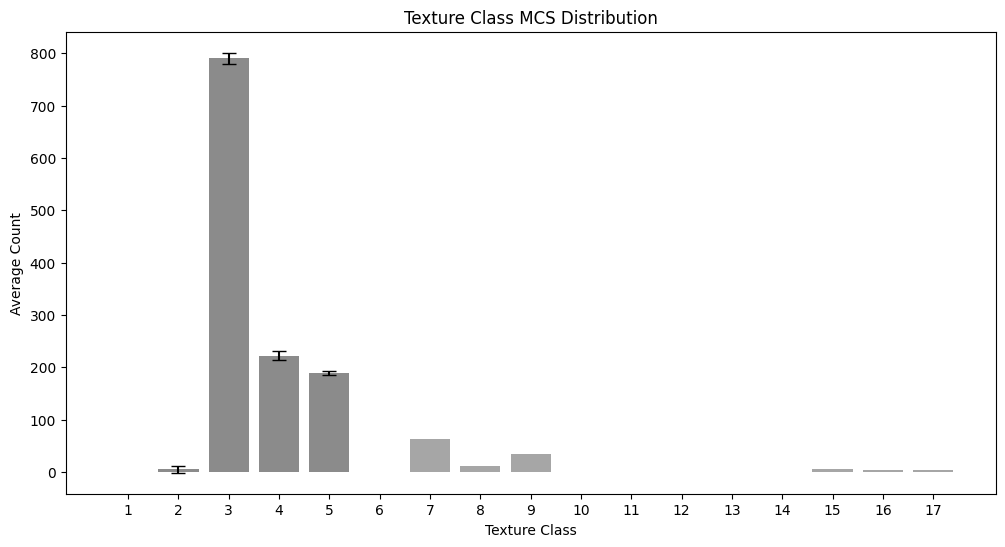

In [13]:

    
# Show a bar chart with the texture classes on the x-axis and the count on the y-axis
# The bars should show the average count for each texture class across all simulations
# And also indicate the standard deviation as error bars

# Prepare data for plotting
texture_classes = range(1, 18)
means = [globals()[f'results_df_{i}']['sum'].mean() for i in texture_classes]
stds = [globals()[f'results_df_{i}']['sum'].std() for i in texture_classes]

# Only show error bars where std is not zero
nonzero_indices = [i for i, std in enumerate(stds) if std > 0]
nonzero_classes = [texture_classes[i] for i in nonzero_indices]
nonzero_means = [means[i] for i in nonzero_indices]
nonzero_stds = [stds[i] for i in nonzero_indices]

plt.figure(figsize=(12, 6))
bars = plt.bar(texture_classes, means, color='grey', alpha=0.7)
plt.bar(nonzero_classes, nonzero_means, yerr=nonzero_stds, capsize=5, alpha=0.7, color='grey')
plt.ylabel('Average Count')
plt.xlabel('Texture Class')
plt.title('Texture Class MCS Distribution')
plt.xticks(texture_classes)
plt.savefig('Exports/sensitivity/sand_sensitivity.svg')
plt.show()



In [58]:
min_rank = np.min(results, axis=0)
min_rank = np.sort(min_rank)

max_rank = np.max(results, axis=0)
average_rank = np.mean(results, axis=0)
std_dev_rank = np.std(results, axis=0)

print(min_rank)
print(max_rank)
print(average_rank)
print(std_dev_rank)

[0.00149925 0.00149925 0.00149925 ...        nan        nan        nan]
[0.00224888 0.00224888 0.00374813 ... 0.0029985  0.00224888 0.00224888]
[0.00224888 0.00224888 0.00374813 ... 0.0029985  0.00224888 0.00224888]
[3.03576608e-18 3.03576608e-18 8.67361738e-19 ... 8.67361738e-19
 3.03576608e-18 3.03576608e-18]


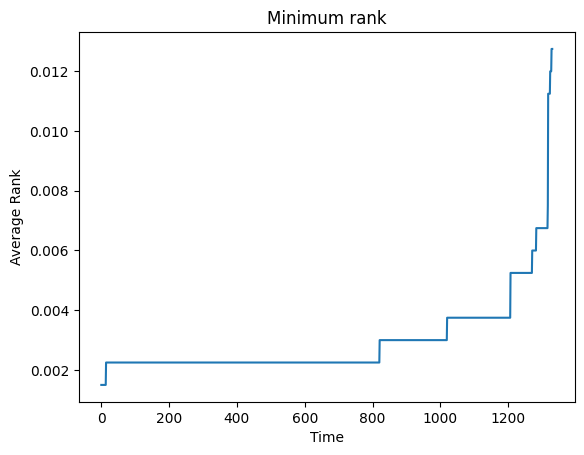

In [ ]:
# Plot the average rank in a graph
plt.plot(min_rank)
plt.title('Minimum rank')
plt.xlabel('Time')
plt.ylabel('Minimum Rank')
plt.show()

In [ ]:
def mcs_simulation(ksat_data, wcs_data, alt_dev_data, weights, types, n_simulations, std_dev):
    # Get the shape of the input data (assuming they are 3D arrays with the same shape)
    data_shape = ksat_data.shape[1:]  # This will give (3422, 3398)

    # Initialise an array to store the results of the simulations
    results = np.zeros((n_simulations, *data_shape))  # Shape: (n_simulations, 3422, 3398)

    for i in tqdm(range(n_simulations)):
        # Generate random weights from a normal distribution centred at the original weights
        random_weights = np.random.normal(weights, std_dev)

        # Ensure weights are positive
        random_weights = np.abs(random_weights)

        # Normalise weights so they sum to 1
        random_weights = random_weights / np.sum(random_weights)

        # Run the smca_model with the random weights
        result = smca_model.model(ksat_data, wcs_data, alt_dev_data, random_weights, types)

        # Set values below a certain threshold to NaN
        result[result < -100] = np.nan

        # Store the result
        results[i] = result

    # Calculate statistics from the results
    min_rank = np.min(results, axis=0)
    max_rank = np.max(results, axis=0)
    average_rank = np.mean(results, axis=0)
    std_dev_rank = np.std(results, axis=0)

    return min_rank, max_rank, average_rank, std_dev_rank